# Modeling Non-pharmaceutical Interventions in Epydemix

When modeling epidemics, non-pharmaceutical interventions are essential for simulating strategies to mitigate the spread of disease, such as quarantine, masking, school closures, or behavioral changes. In this tutorial we will see how to implement this in **Epydemix**. First, imports:

In [1]:
from epydemix import EpiModel
from epydemix.visualization import plot_quantiles, plot_spectral_radius
from epydemix.population import load_epydemix_population
from epydemix.utils import compute_simulation_dates
import matplotlib.pyplot as plt

import seaborn as sns   
colors = sns.color_palette("Dark2")

In this tutorial, we will create two SEIR models using the Italian population and contact matrices. One model will incorporate interventions, while the other will exclude them, allowing for a clear comparison of their effects.

In [2]:
# import population and set simulation dates
population = load_epydemix_population("Italy")
simulation_dates = compute_simulation_dates("2024-01-01", "2024-08-31")

# create model with interventions and set population 
model_interventions = EpiModel(predefined_model="SEIR", transmission_rate=0.045)
model_interventions.set_population(population)

# create model without interventions and set population
model_nointerventions = EpiModel(predefined_model="SEIR", transmission_rate=0.045)
model_nointerventions.set_population(population)

In **Epydemix**, interventions can be modeled in two main ways: using `add_interventions` or `override_parameter`. Both methods allow you to modify the behavior of the system dynamically during a simulation.

### Using `add_interventions`
The `add_interventions` method allows you to introduce interventions explicitly as events that occur at specific times and target particular layers of the contact matrices. This approach is ideal for modeling interventions with focused effects on specific contact patterns. For example, it can be used to simulate the closure of schools or workplaces, effectively reducing interactions in those specific settings while leaving other contact layers unaffected.

Interventions added via `add_interventions` can be further parameterized in two ways:

1. **Using a Reduction Factor**: You can specify a reduction factor that indicates the extent to which contacts in a given setting decrease as a result of the intervention. For example, a reduction factor of 0.3 means that contacts are reduced by 70%. This factor is applied uniformly across the entire specified contact matrix, reducing all elements by the same proportion. 

2. **Providing a Custom Contact Matrix**: If the intervention not only reduces the overall contact level but also alters the relative contact rates between groups, you can directly supply the contact matrix to be used during the specified period of the intervention. This approach allows for more granular control over how contacts are adjusted in response to the intervention.

For simplicity, in this tutorial we consider two interventions of this type:
- **School Closure**: Reduces contacts in the school layer by 70% (reduction factor: 0.3).
- **Workplace Closure**: Reduces contacts in the workplace layer by 65% (reduction factor: 0.35).


In [3]:
# Define the interventions by using a multplying factor
model_interventions.add_intervention(layer_name="work", start_date="2024-01-15", end_date="2024-02-15", reduction_factor=0.3, name="workplace closure")
model_interventions.add_intervention(layer_name="school", start_date="2024-03-01", end_date="2024-05-01", reduction_factor=0.35, name="school closure")

We can visualize the impact of these interventions on contact dynamics by plotting the spectral radius of the overall contact matrix over time. The spectral radius is defined as the largest eigenvalue of the contact matrix. In age-structured epidemic models, such as SIR-like or SEIR-like models, the basic reproductive number ($R_0$) is directly proportional to the spectral radius. This approach provides a clear, quantitative way to evaluate the effectiveness of interventions in reducing transmission.

<Axes: title={'center': 'Contact Pattern Intensity - Overall Layer'}, xlabel='Date', ylabel='Spectral radius'>

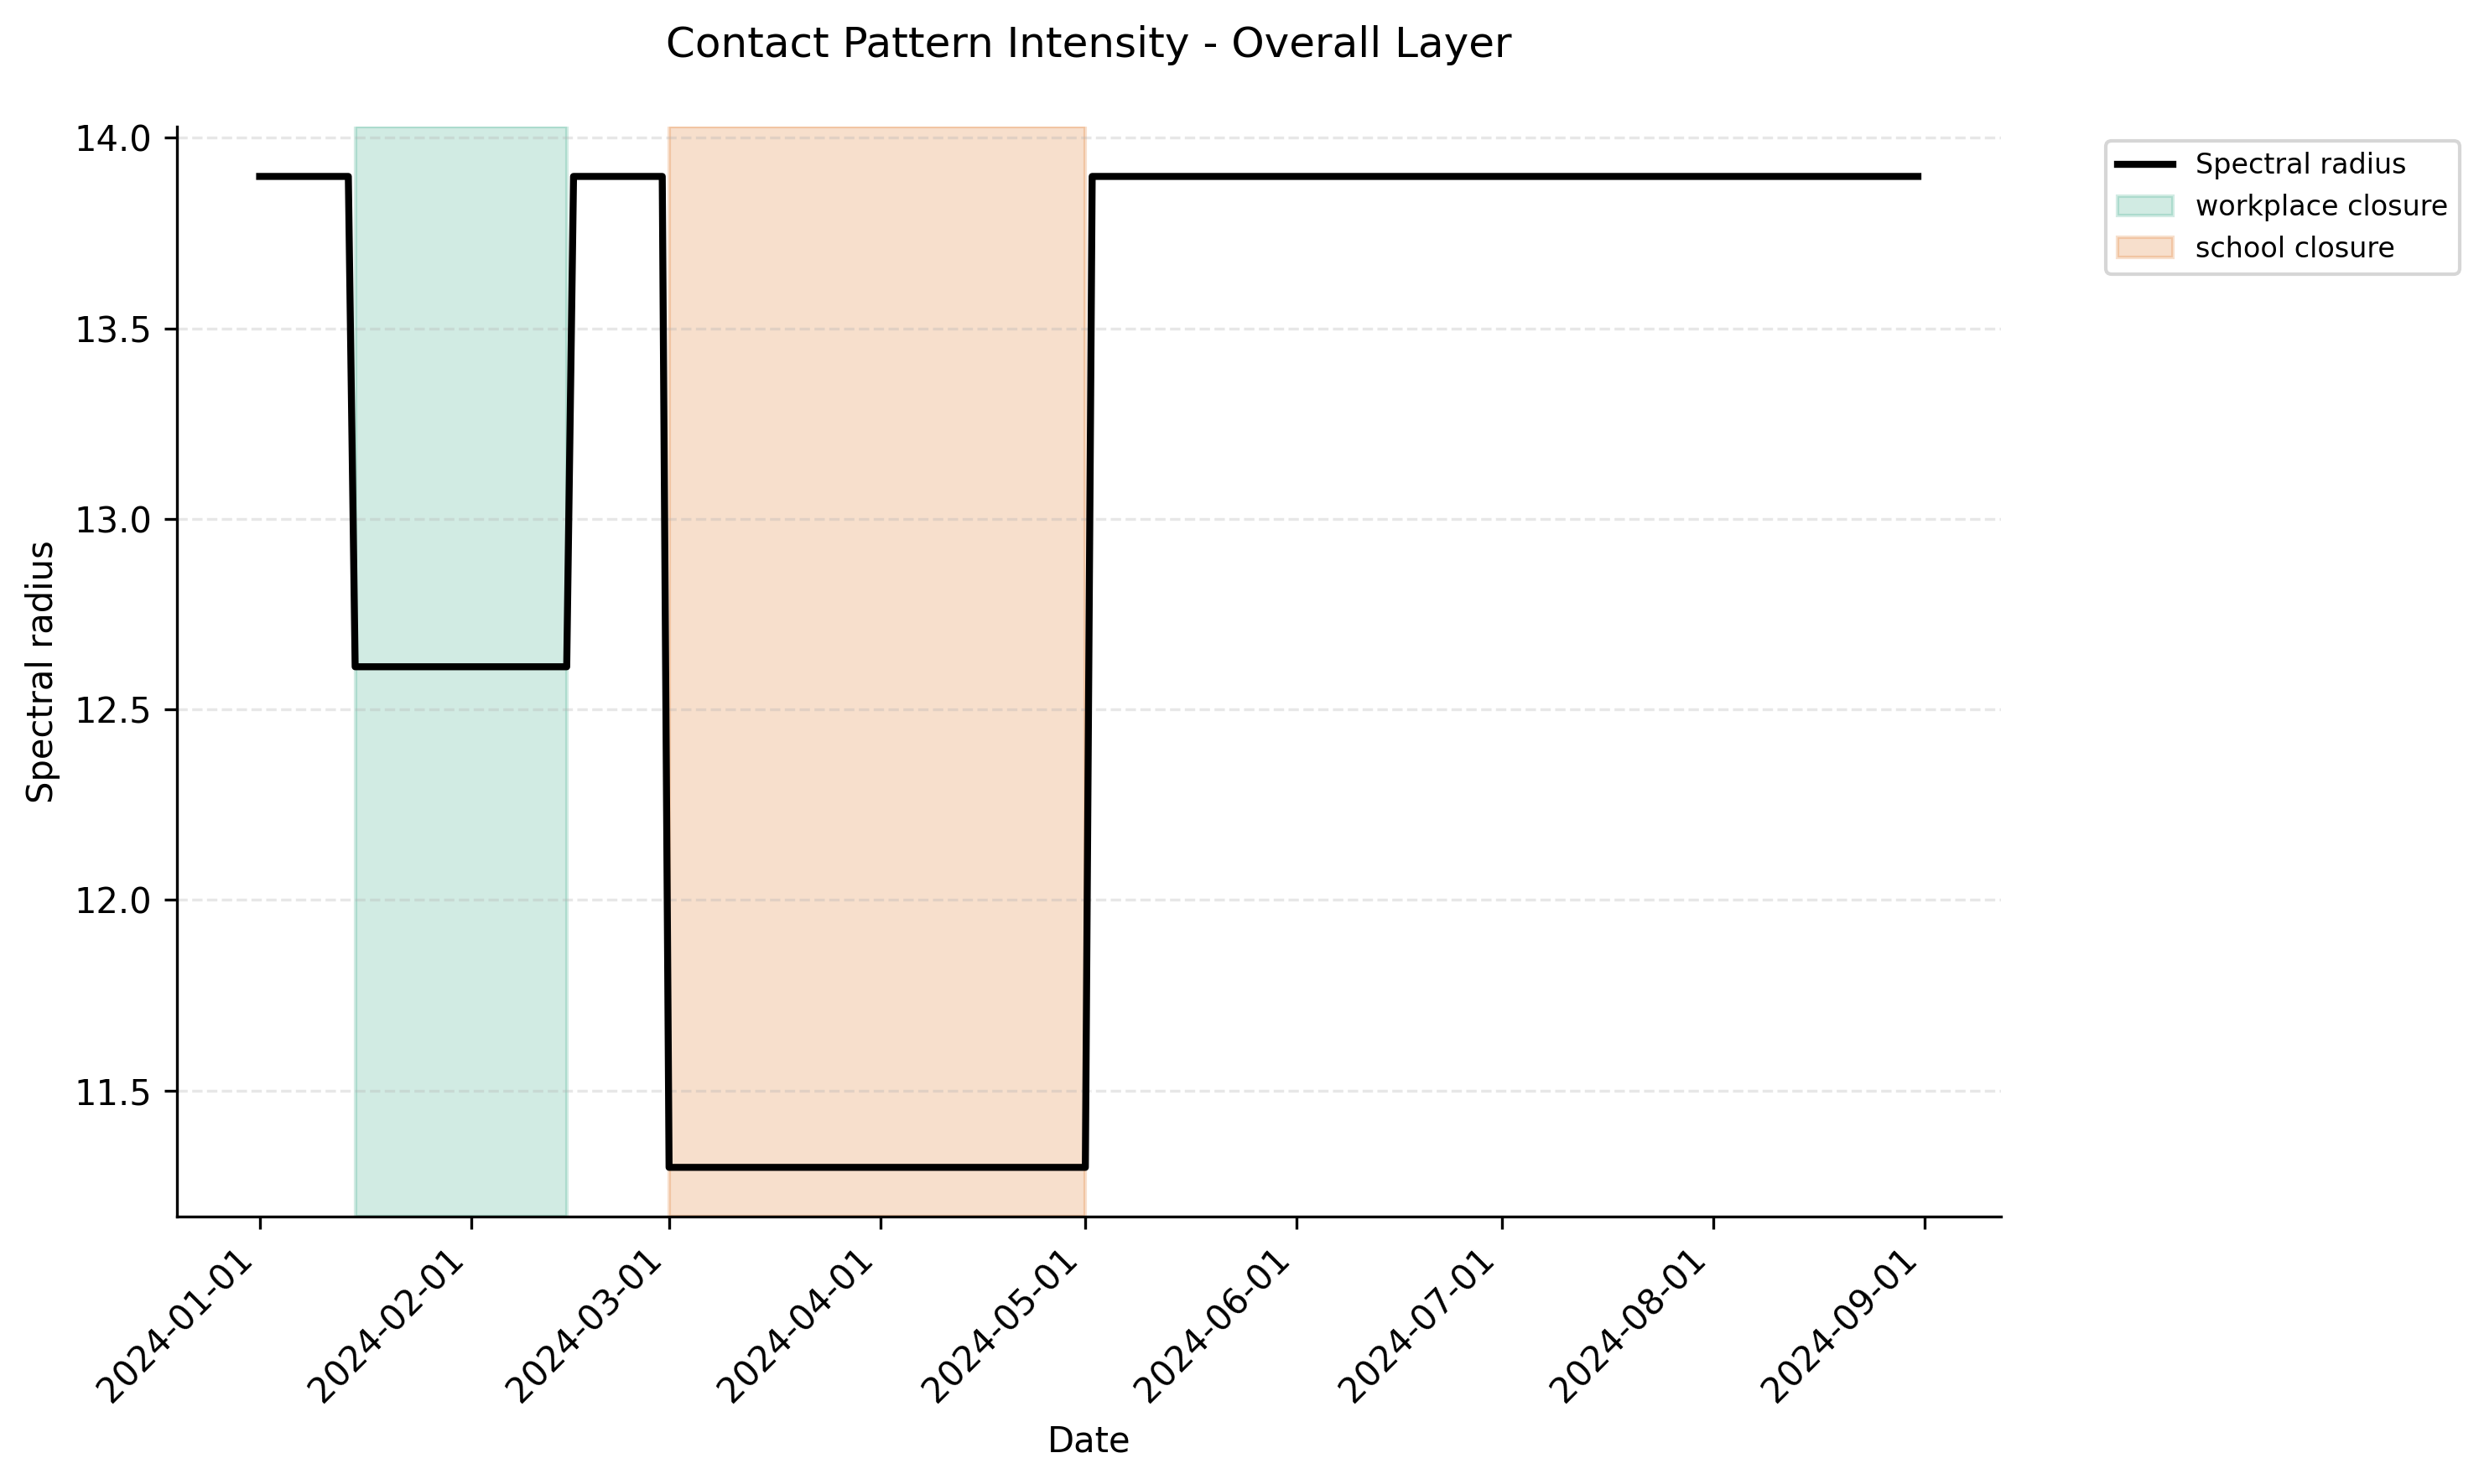

In [4]:
# compute contact reductions (in order to plot them)
model_interventions.compute_contact_reductions(simulation_dates)

# plot
plot_spectral_radius(model_interventions)

### Using `override_parameter`
The `override_parameter` method enables you to implement interventions dynamically by modifying transition parameters during specific time frames. For instance, introducing widespread masking can reduce the transmission parameter, while enhanced testing efforts can improve the identification of infected individuals and subsequently shorten the infectious period. This method provides a flexible way to simulate the impact of interventions by directly altering key model parameters in response to evolving conditions.

In this tutorial we imagine the introduction of interventions, such as mandatory masking and social distancing policies, that reduce the transimssion parameter over a specified time period.

In [5]:
model_interventions.override_parameter(start_date="2024-02-01", 
                                       end_date="2024-08-31",
                                       name="transmission_rate",
                                       value=0.02)

Finally, we simulate the two models—one with interventions and the other without—and compare their outcomes by plotting the number of infected individuals over time.

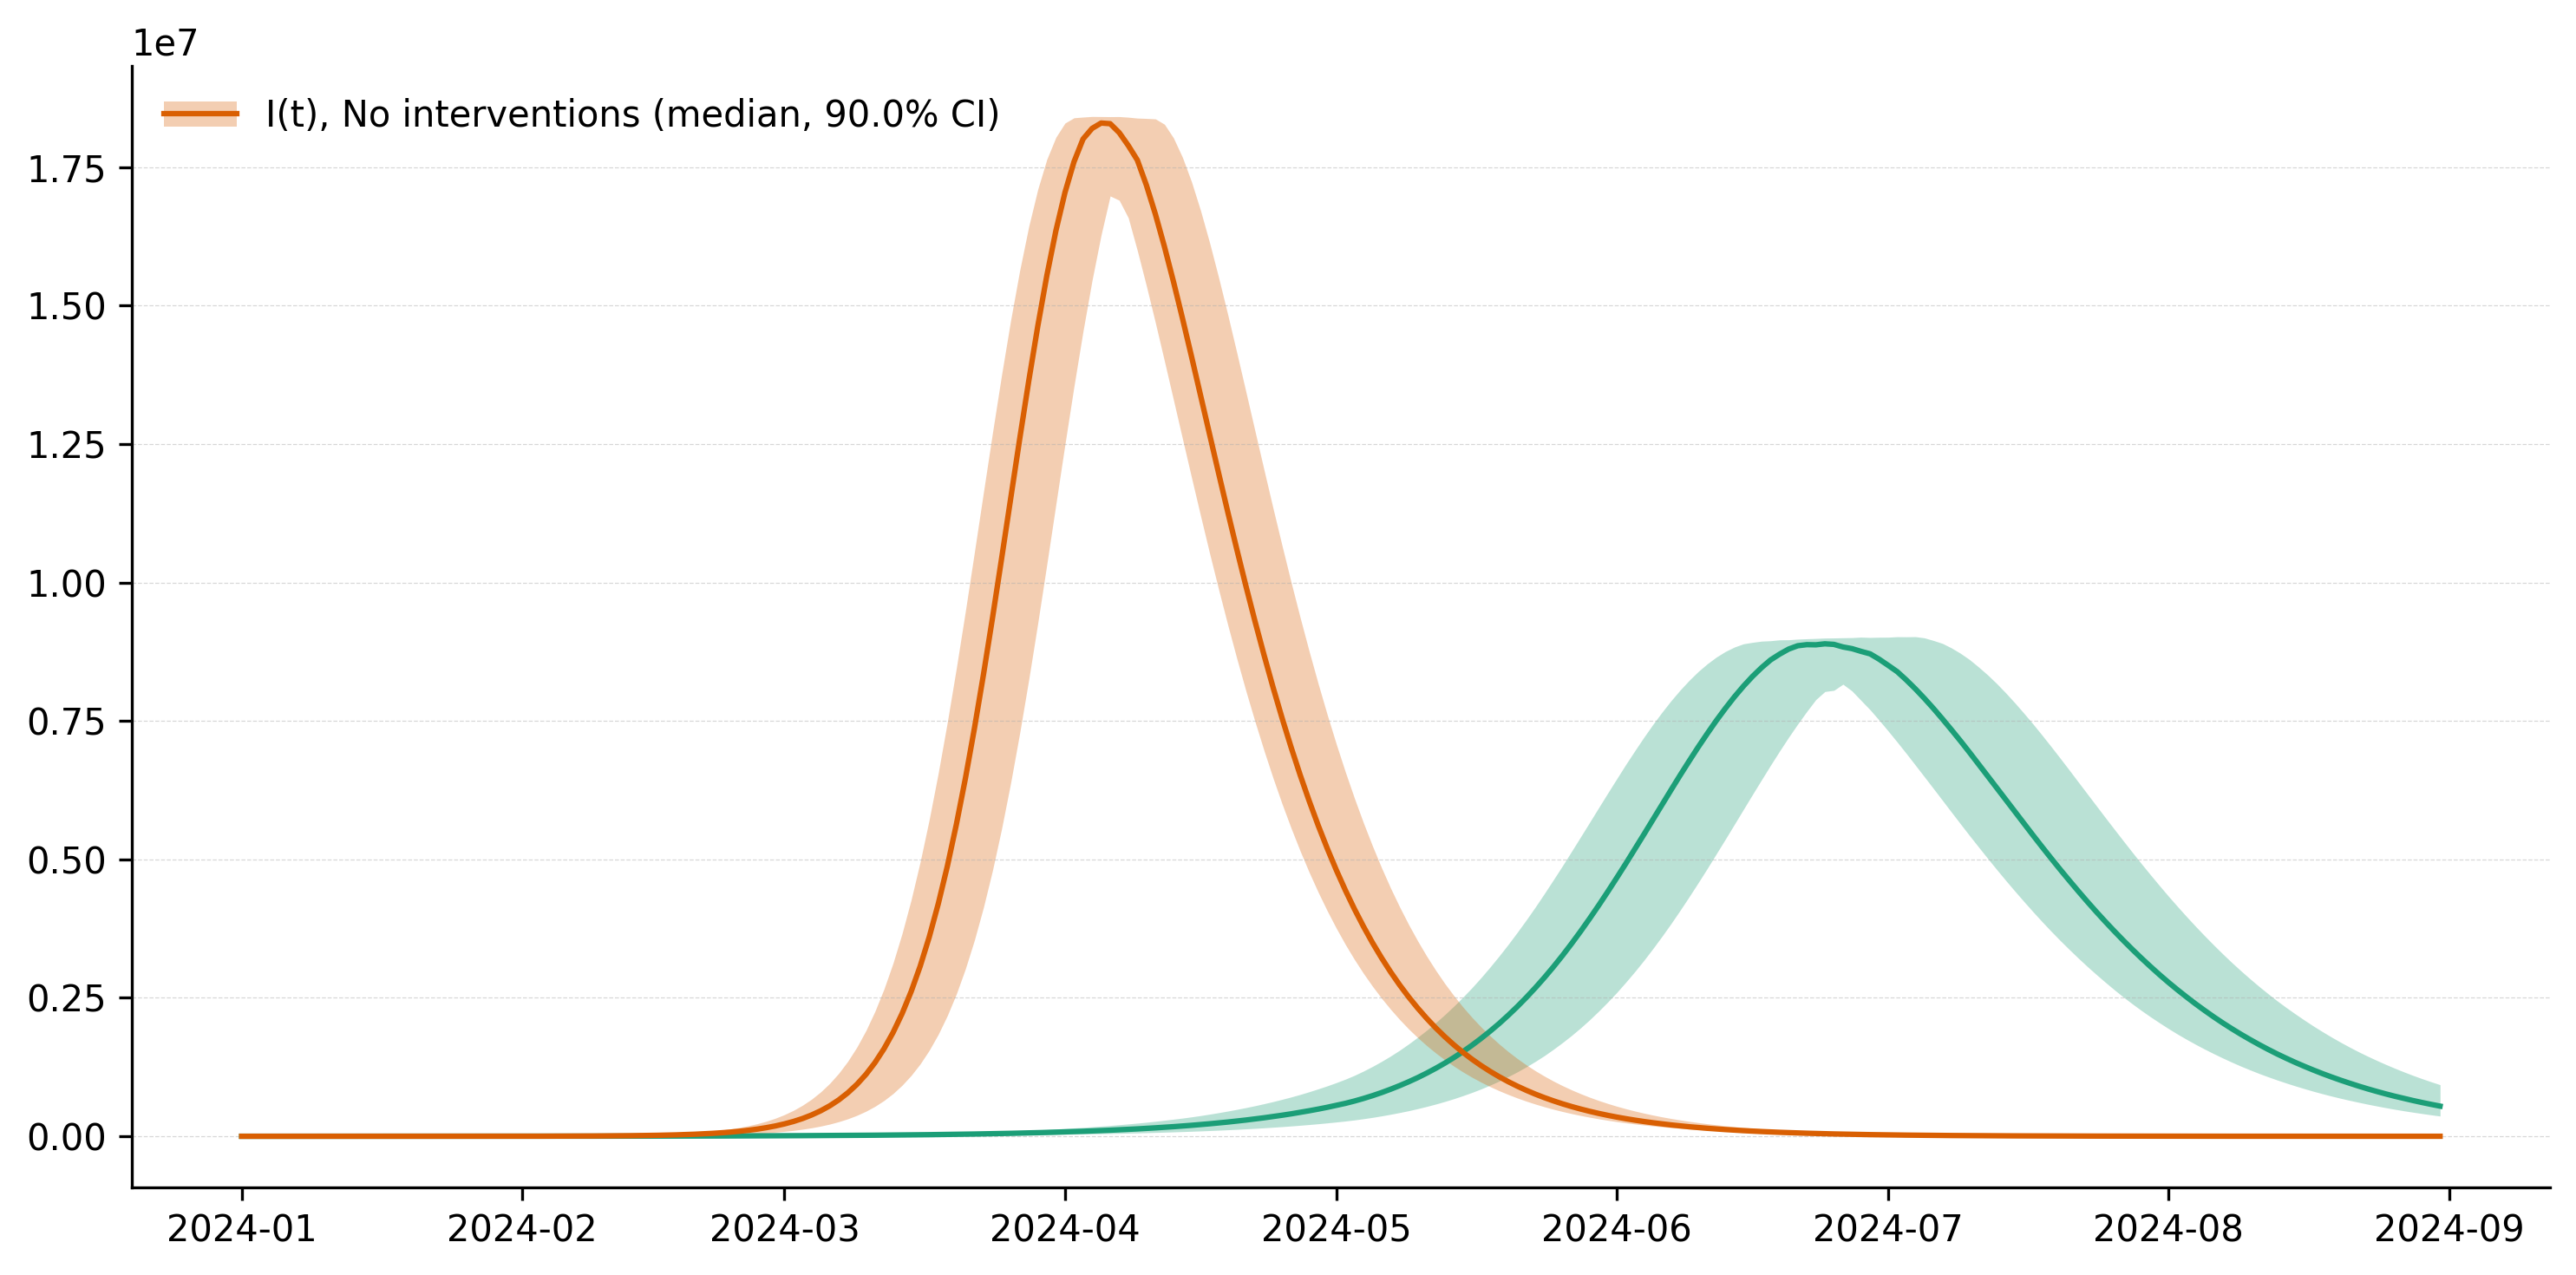

In [6]:
# simulate with 10 infected individuals
results_interventions = model_interventions.run_simulations(start_date="2024-01-01", end_date="2024-08-31", Nsim=100, 
                                                            percentage_in_agents=10 / model_interventions.population.Nk.sum())

results_nointerventions = model_nointerventions.run_simulations(start_date="2024-01-01", end_date="2024-08-31", Nsim=100, 
                                                                percentage_in_agents=10 / model_nointerventions.population.Nk.sum())

# plot results
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)

df_interventions = results_interventions.get_quantiles_compartments()
ax = plot_quantiles(df_interventions, columns=["Infected_total"], colors=colors[0], labels="I(t), Interventions", ax=ax)

df_no_interventions = results_nointerventions.get_quantiles_compartments()
ax = plot_quantiles(df_no_interventions, columns=["Infected_total"], colors=colors[1], labels="I(t), No interventions", ax=ax) 

In the model with interventions, we observe that the infection peak is both significantly smaller and delayed compared to the model without interventions. 

With little additional effort, we can quantify the impact of the interventions by:
- **Computing Averted Infections**: Calculating the difference in the total number of infections between the two models over the entire simulation period.
- **Delta in Peak Size**: Measuring the reduction in the maximum number of infected individuals at the peak.

Text(0.5, 1.0, 'Delta in peak size (%)')

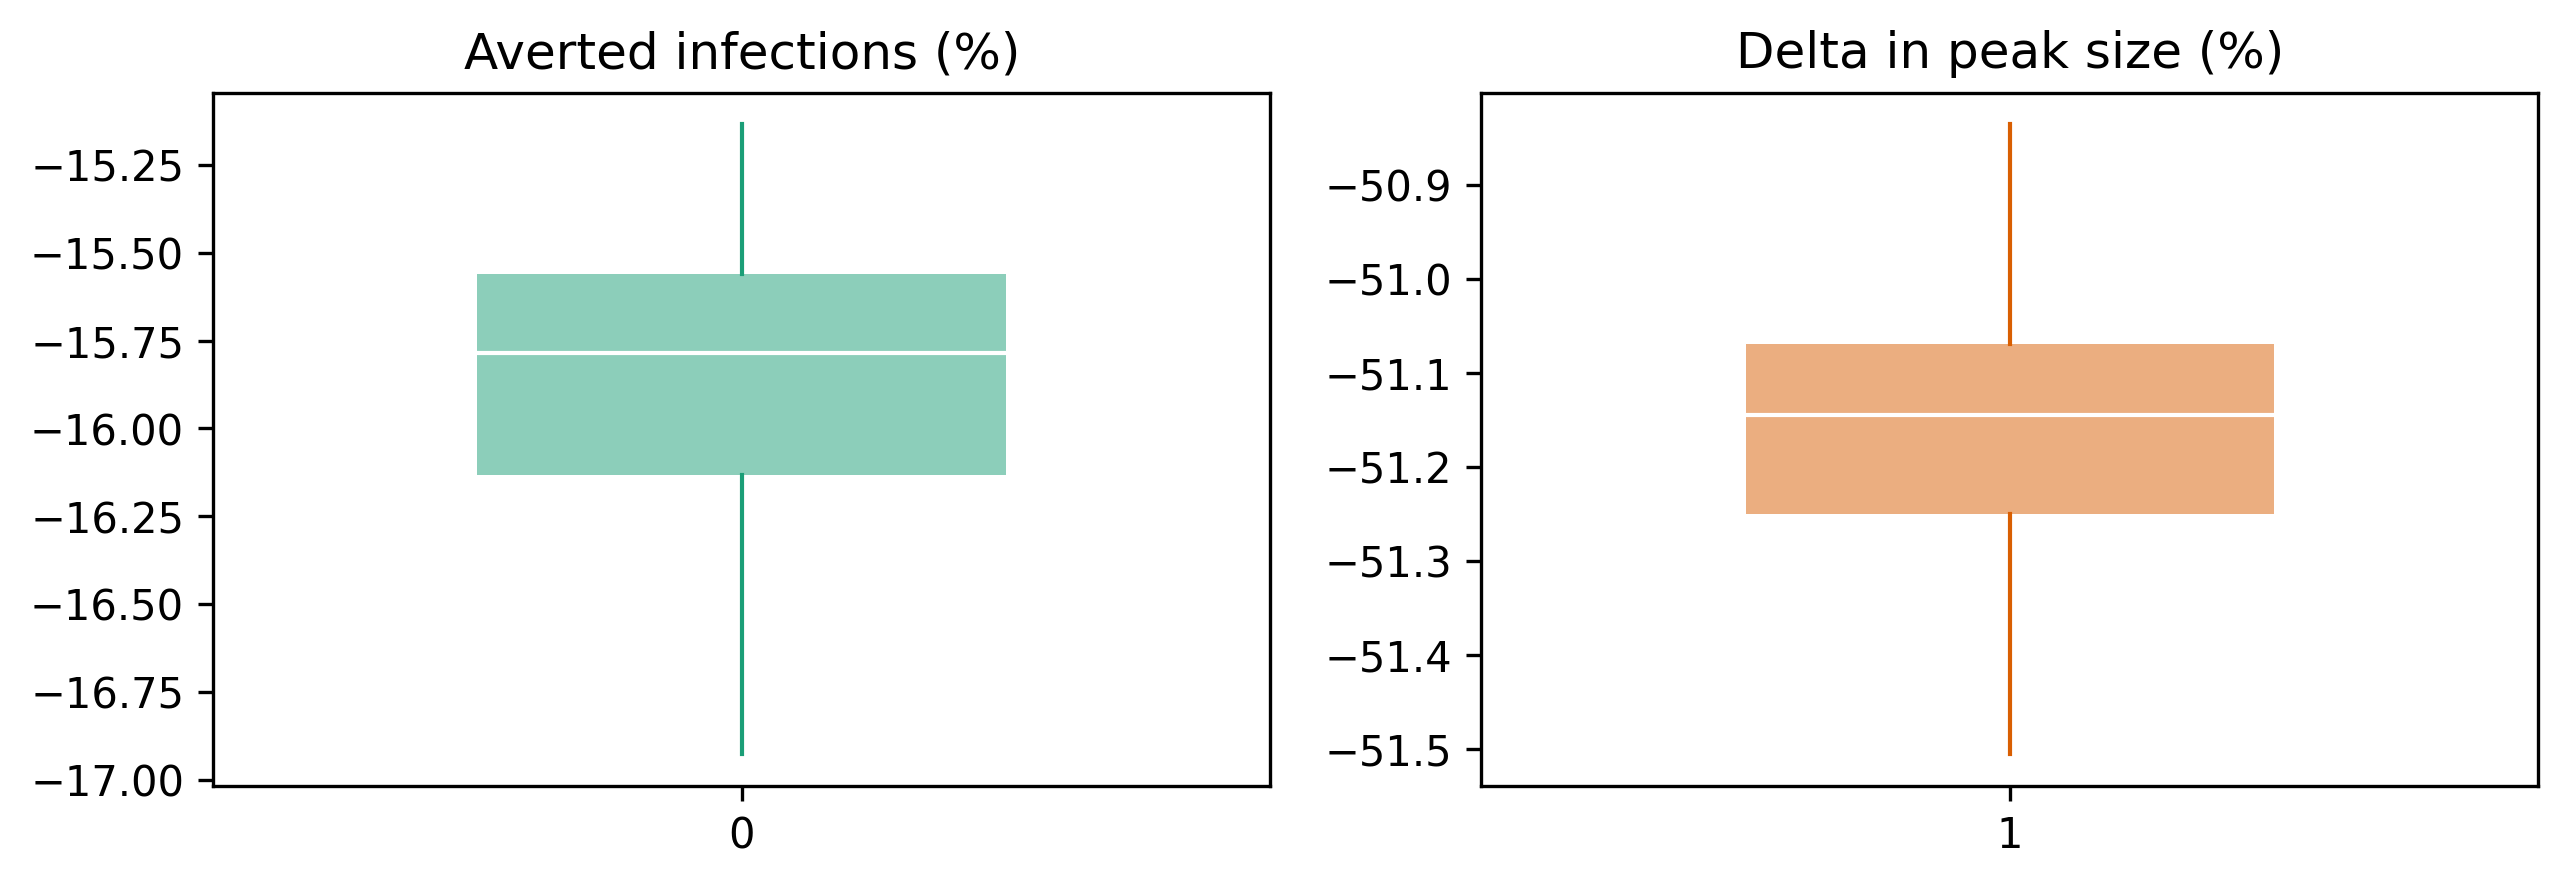

In [7]:
# get full trajectories
trajectories_interventions = results_interventions.get_stacked_compartments()
trajectories_nointerventions = results_nointerventions.get_stacked_compartments()

# compute attack rates and averted infections
attack_rate_int = trajectories_interventions["Recovered_total"][:, -1]
attack_rate_noint = trajectories_nointerventions["Recovered_total"][:, -1]
averted_infections_perc = 100 * (attack_rate_int - attack_rate_noint) / attack_rate_noint

# compute peak size and delta in peak size
peak_size_int = trajectories_interventions["Infected_total"].max(axis=1)
peak_size_noint = trajectories_nointerventions["Infected_total"].max(axis=1)
delta_peak_size_perc = 100 * (peak_size_int - peak_size_noint) / peak_size_noint

# plot 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3), dpi=300)

axes[0].boxplot(averted_infections_perc, positions=[0], widths=0.5, patch_artist=True, 
            boxprops=dict(facecolor=colors[0], alpha=0.5, linewidth=0), 
            medianprops=dict(color="white"), 
            whiskerprops=dict(color=colors[0]), showfliers=False, showcaps=False)


axes[1].boxplot(delta_peak_size_perc, positions=[1], widths=0.5, patch_artist=True, 
            boxprops=dict(facecolor=colors[1], alpha=0.5, linewidth=0), 
            medianprops=dict(color="white"), 
            whiskerprops=dict(color=colors[1]), showfliers=False, showcaps=False);

axes[0].set_title("Averted infections (%)")
axes[1].set_title("Delta in peak size (%)")